In [77]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal

In [78]:
data_folder = '/content/drive/MyDrive/DSP/'
# data_folder = './data/'  # ВЫБРАТЬ ЭТО ЕСЛИ ЗАПУСКАЕШЬ ИЗ РЕПОЗИТОРИЯ

# Шаг 1 Записываем свипер

In [107]:
orig, sr = sf.read(data_folder + 'sweeper.wav')
recorded, _ = sf.read(data_folder + 'sweeper_recorded.wav')
orig = orig[:,0]
recorded = recorded[:orig.shape[0], 0]
orig = orig[-recorded.shape[0]:]

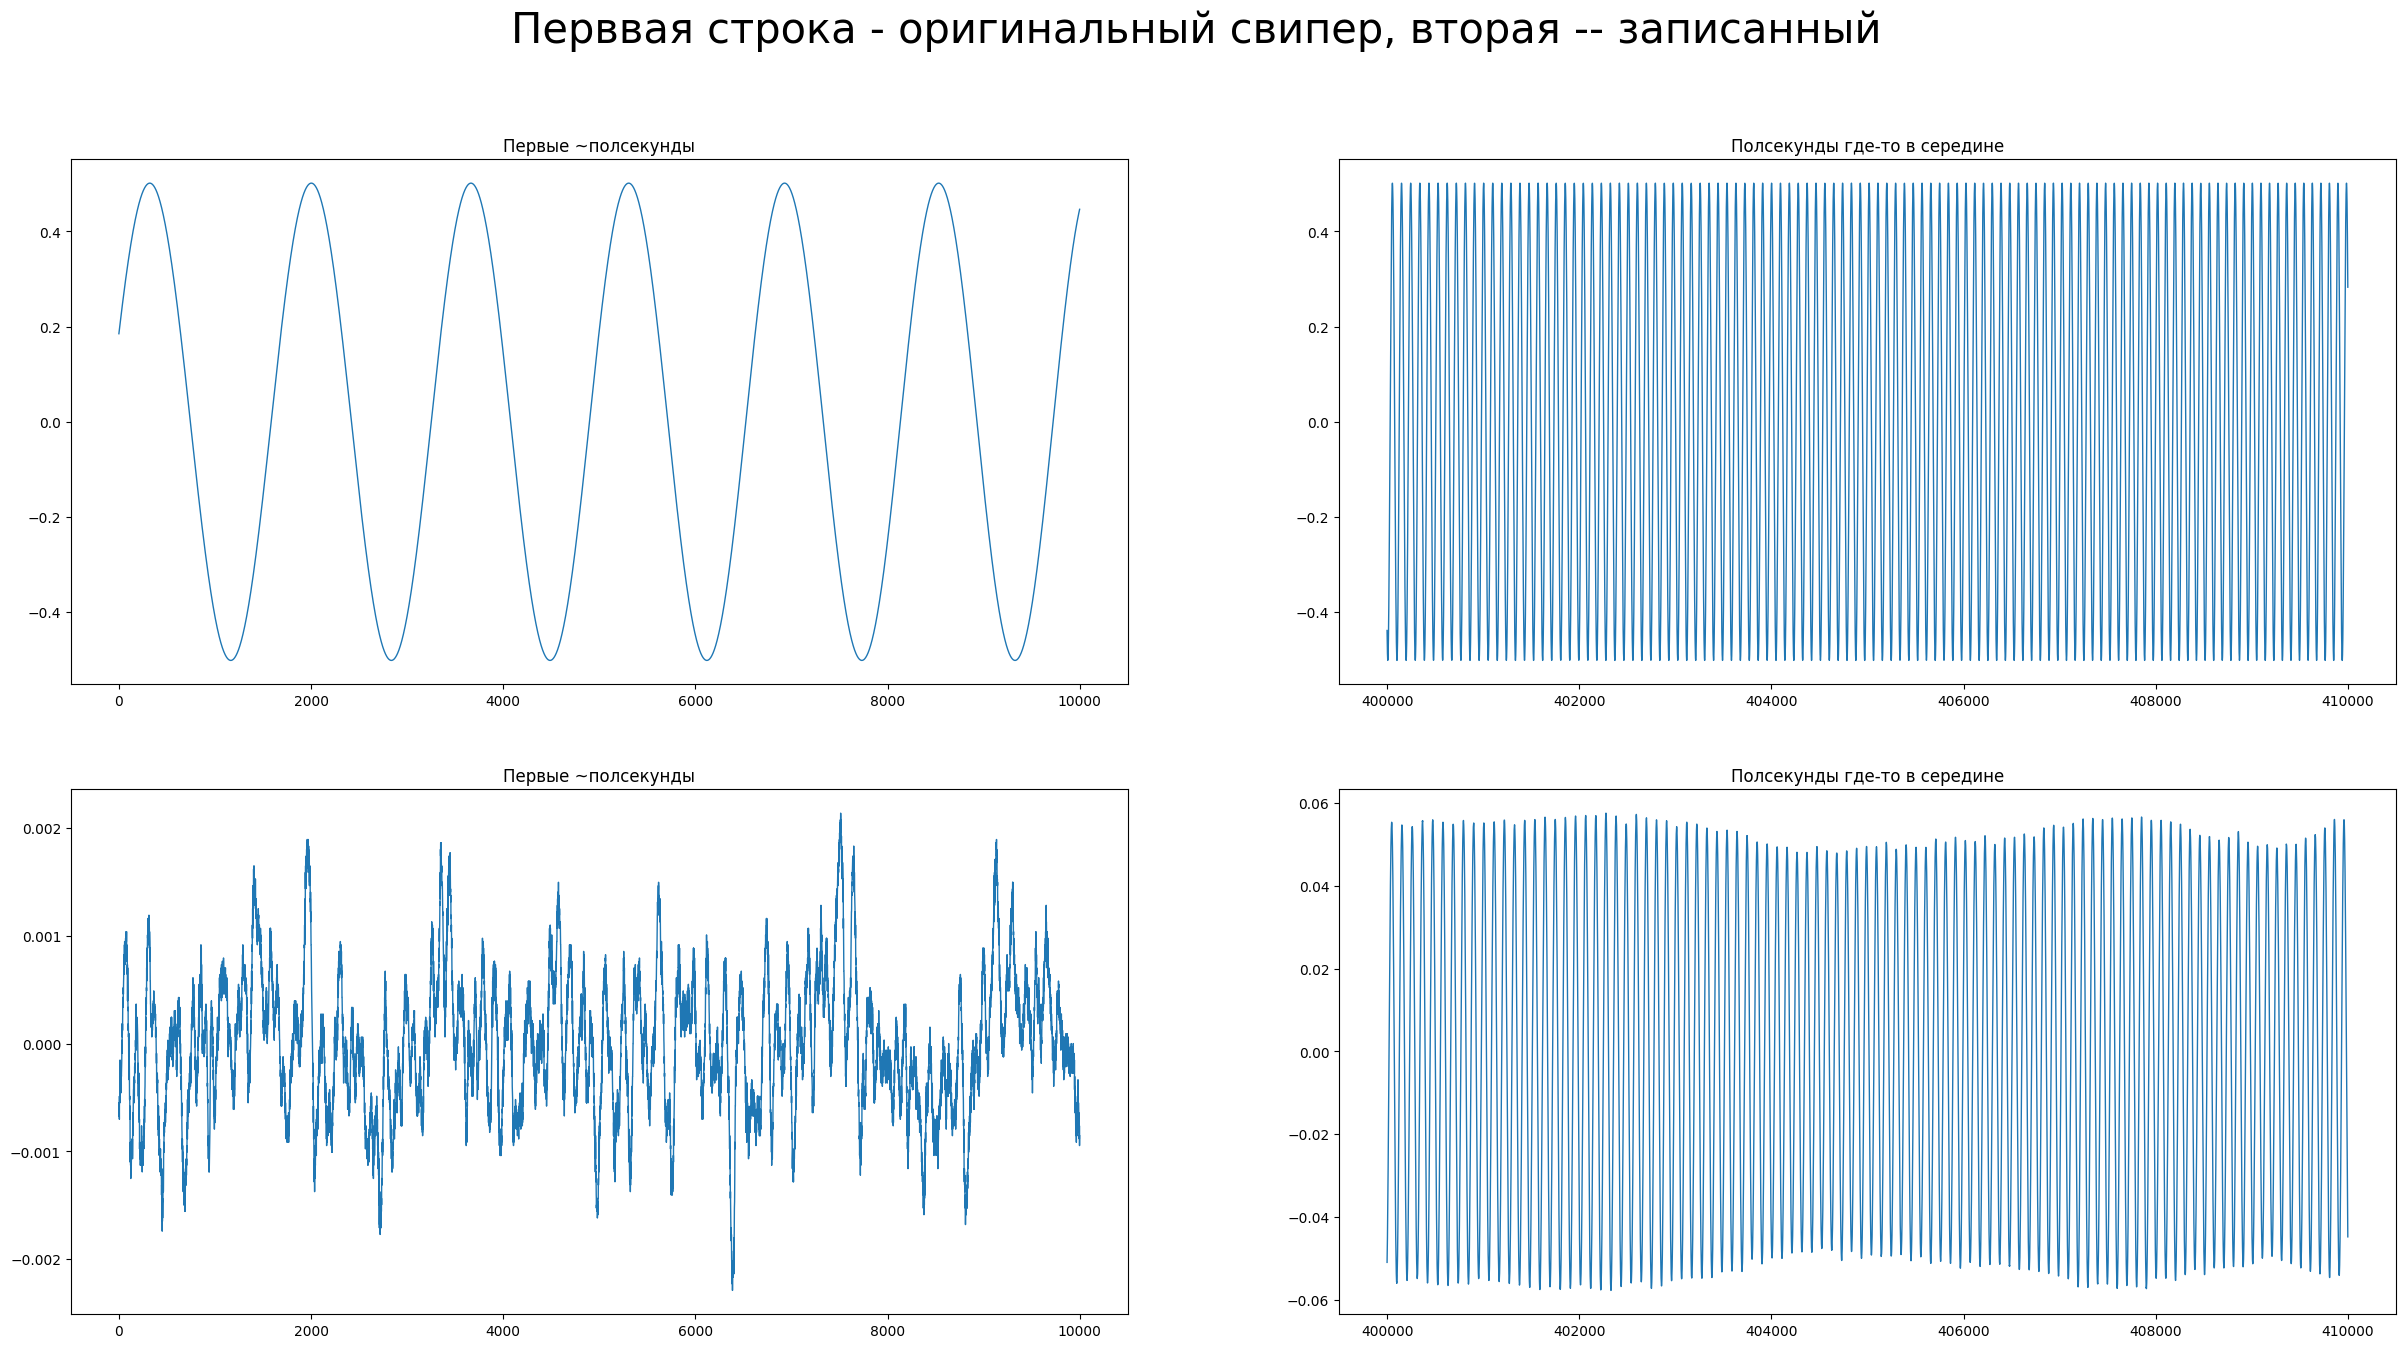

In [108]:
plt.figure(figsize=(30,15))
plt.suptitle('Перввая строка - оригинальный свипер, вторая -- записанный', fontsize=30)

length = 10000
start = 400000

plot_idx = 1
for sample in (orig, recorded):
    plt.subplot(2,2,plot_idx)
    plt.title('Первые ~полсекунды')
    plt.plot(np.arange(length), sample[:length], linewidth=1)

    plt.subplot(2,2,plot_idx+1)
    plt.title('Полсекунды где-то в середине')
    plt.plot(np.arange(start, start+length), sample[start:start+length], linewidth=1)

    plot_idx += 2

Видно, что записанное всё-таки обладает шумами, хоть я и пытался избавиться в шкафу (скорее всего это просто шум самого ноутбука, с которого проигрывалась записть)

# Шаг 2. Переводим свипер и его запись в частотную область

In [109]:
orig_spectrum = np.fft.rfft(orig)
recorded_spectrum = np.fft.rfft(recorded[:orig.shape[0]])

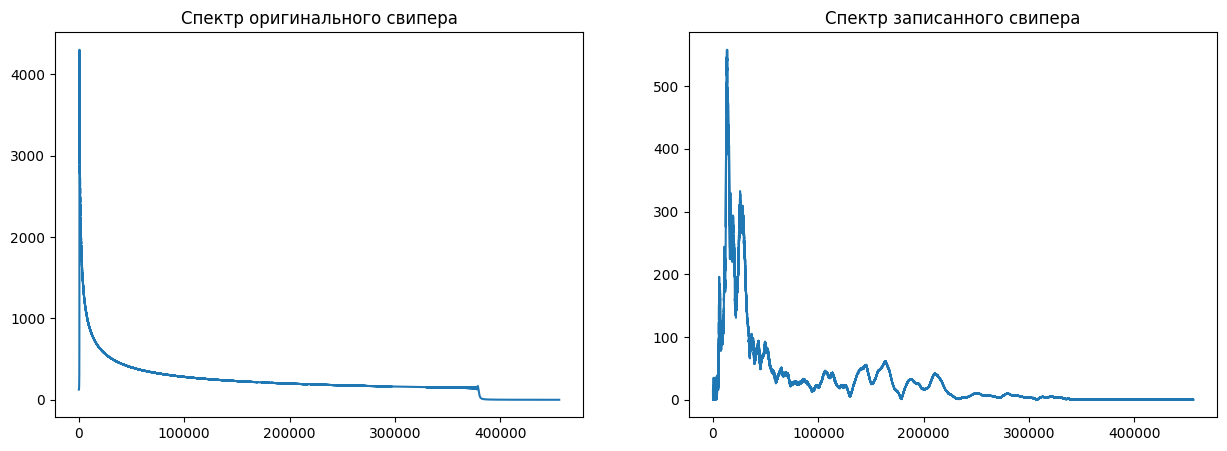

In [112]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Спектр оригинального свипера')
plt.plot(np.abs(orig_spectrum))

plt.subplot(1,2,2)
plt.title('Спектр записанного свипера')
plt.plot(np.abs(recorded_spectrum))
plt.show()

# Шаги 3-6. Бьем спектры на полосы и считаем gain по каждой полосе

In [118]:
def get_bins(spectrum, N_bins = 64):
    """
    Разбивает на полосы частотную область и возвращает среднее значение каждой
    полосы
    """
    # Переходим от комплексных чисел
    spectrum = np.abs(spectrum)

    bins_size = spectrum.shape[0] // N_bins
    avg_amplitude = []

    # Проходимся по каждому бину и берем среднее значение
    for i in range(0, len(spectrum), bins_size):
        avg_amplitude.append(np.mean(spectrum[i:i+bins_size]))

    return np.array(avg_amplitude)

In [143]:
orig_spectrum_bins = get_bins(orig_spectrum)
recorded_spectrum_bins = get_bins(recorded_spectrum)
gain = orig_spectrum_bins / recorded_spectrum_bins

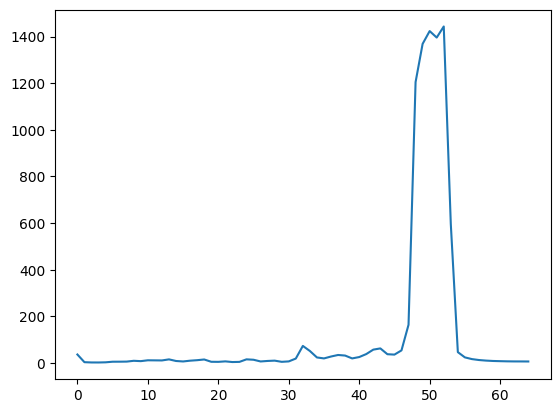

In [144]:
plt.plot(gain)

# Шаг 7-9. Домножаем спектр белого шума пополосно на gain чтобы учесть АЧХ колонки

In [145]:
white_noise, _ = sf.read(data_folder + 'white_noise.wav')
white_noise = white_noise[:,0]

In [146]:
def correct_audio(audio, gain):
    """
    Функция для коррекции аудио с учетом gain.
    В частотной области домножает каждую полосу
    на соответстующее число в gain и возвращает
    измененное аудио
    """
    audio_spectrum = np.fft.rfft(audio)
    N_bins = gain.shape[0]
    bins_size = len(audio_spectrum) // N_bins
    for i in range(0, bins_size * N_bins, bins_size):
        audio_spectrum[i:i+bins_size] *= gain[i // bins_size]
    audio_spectrum[i:] *= gain[-1]
    audio_reversed = np.fft.irfft(audio_spectrum)
    return audio_reversed

In [147]:
white_noise_corrected = correct_audio(white_noise, gain)

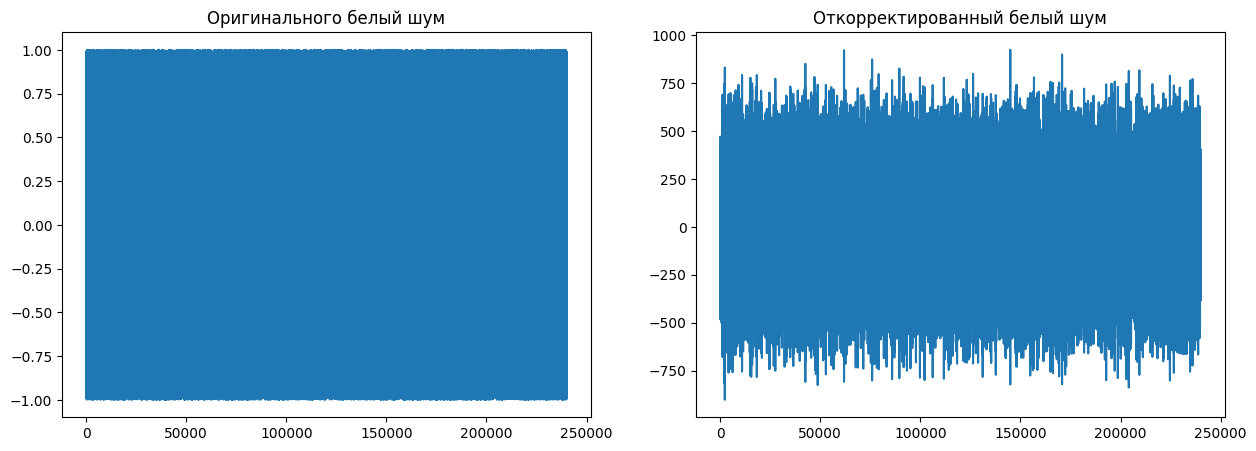

In [148]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Оригинального белый шум')
plt.plot(white_noise)

plt.subplot(1,2,2)
plt.title('Откорректированный белый шум')
plt.plot(white_noise_corrected)
plt.show()

In [149]:
sf.write(data_folder + 'white_noise_corrected.wav', white_noise_corrected, samplerate=48000)

# Шаг 10-11. Вычленяем импульсный отклик из записанного скорректированного белого шума

In [150]:
white_noise, _ = sf.read(data_folder + 'white_noise.wav')
white_noise = white_noise[:,0]

white_noise_corrected_recorded, _ = sf.read(data_folder + 'white_noise_corrected_recorded.wav')
white_noise_corrected_recorded = white_noise_corrected_recorded[:white_noise.shape[0],0]

In [151]:
def deconvolve(x, y):
    y = y[:len(x)]
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    H = Y/X
    h = np.fft.irfft(H)
    return h

In [152]:
h = deconvolve(white_noise, white_noise_corrected_recorded)

In [153]:
gt, _ = sf.read(data_folder + 'gt.wav')
gt_convolved = signal.fftconvolve(gt, h, 'full')[:len(gt)]

In [154]:
sf.write(data_folder + 'gt_convolved.wav', gt_convolved, samplerate=48000)

Записанный файл лежит в gt_recorded.wav.  
Получилось не очень, в этом файле не разбирается даже сам голос.  
Какие причины могут быть? Кроме того, что эксперимент поставлен в неидеальных условиях, мне кажется, есть какой-то недочет в алгоритме.  
Мне кажется, при вычислении гейна нужно использовать спектр не всего свипера, а спектр небольших промежутков, чтобы потом для каждой частоты (читай, для каждой полосы частот) можно было вычислить гейн. Это сработает, так как свипер в каждый момент времени имеет только одну частоту, поэтому разбиение на полосы по времени будет эквивалентно разбиению на полосы по частоте